## Ingeniería de características

Trabajemos con las características y el objetivo para poder desarrollar un modelo de calidad. Haremos un escalado One Hot a las caracteristicas para que este sea uniforme entre las caracteristicas y funcione con las numericas.

In [34]:
data = merged_df.copy()
data['ActiveContract'] = data['EndDate'].isna().astype(int)

### Caracteristicas innecesarias

Nos desharemos de las columnas que no aportan información predictiva significativa, como 'gender', 'ContractDuration' y 'SeniorCitizen', que tienen una correlación irrelevante. Las columnas 'MonthlyCharges' y 'TotalCharges' tienen una alta correlación entre sí, por lo que podría haber información redundante. Sin embargo, estas son importantes para el análisis de ingresos, por lo que las mantendremos en las características.

In [36]:
data.drop(columns=['gender', 'SeniorCitizen', 'customerID', 'EndDate'], inplace=True)

### Escalado de caracteristicas

Utilizaremos un escalado estándar en las características 'MonthlyCharges' y 'TotalCharges'. La característica 'Type' quedará igual ya que la escala es prácticamente la misma; además, tiene un peso alto en la correlación con la característica objetivo. Para las caracteristicas categoricas utilizaremos One Hot.

In [37]:
categorical_transformer = OneHotEncoder(drop='first')
scaler = StandardScaler()

categorical_columns = ['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'MultipleLines', 'PaperlessBilling', 'PaymentMethod', 'Type']
numerical_columns = ['MonthlyCharges', 'TotalCharges']

categorical_encoded = categorical_transformer.fit_transform(data[categorical_columns]).toarray()
categorical_encoded_df = pd.DataFrame(categorical_encoded, 
                                      columns=categorical_transformer.get_feature_names_out(categorical_columns))

categorical_encoded_df.index = data.index
data = pd.concat([data.drop(columns=categorical_columns), categorical_encoded_df], axis=1)

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### Manejor de fechas

Convertiremos las columnas 'BeginDate' y 'EndDate' en varias caracteristicas; una para cada componente.

In [38]:
data['BeginDate_year'] = data['BeginDate'].dt.year
data['BeginDate_month'] = data['BeginDate'].dt.month
data['BeginDate_day'] = data['BeginDate'].dt.day

data = data.drop(columns=['BeginDate'])

### Analisis de clases

In [39]:
data['ActiveContract'].value_counts()

1    5174
0    1869
Name: ActiveContract, dtype: int64

Hay una descompensación en las clases. Algunos modelos, como Random Forest o XGBClassifier, manejan correctamente este problema. En otros modelos, lo podemos abordar de distintas formas, como el sobremuestreo o la asignación de pesos a las clases, e incluso el submuestreo (aunque no es una buena idea debido a la cantidad de datos disponibles). Primero, vamos a dividir el conjunto de datos para poder aplicar una técnica de sobremuestreo al conjunto de entrenamiento.

Haremos la división de los datos en una proporción 70/15/15 para entrenamiento, prueba y validación, respectivamente.

In [40]:
X = data.drop(columns=['ActiveContract'])
y = data['ActiveContract']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1764, random_state=random_state)

print("Tamaño de entrenamiento:", len(X_train))
print("Tamaño de validación:", len(X_valid))
print("Tamaño de prueba:", len(X_test))

Tamaño de entrenamiento: 4930
Tamaño de validación: 1056
Tamaño de prueba: 1057


Ahora realizamos una tecnica de sobremuestreo al conjunto de entrenamiento. Haremos una copia de este, asi podremos utilizar ambas tecnicas en los modelos y ver cual funciona mejor.

In [41]:
smote = SMOTE(random_state=random_state, n_jobs=5, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Tamaño original del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de entrenamiento después de SMOTE:", len(X_train_resampled))

Tamaño original del conjunto de entrenamiento: 4930
Tamaño del conjunto de entrenamiento después de SMOTE: 7194


c:\Users\Martin\anaconda3\envs\ml\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [42]:
y_train_resampled.value_counts()

1    3597
0    3597
Name: ActiveContract, dtype: int64

In [43]:
X_train_resampled

,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,...,MultipleLines_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Type_One year,Type_Two year,BeginDate_year,BeginDate_month,BeginDate_day
0,-1.489359,-0.957426,0.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.0,2019,9,1
1,1.026602,0.652649,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,2016,9,1
2,0.700890,-0.931970,0.000000,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.0,0.0,2019,9,1
3,-1.186912,-0.948603,1.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.0,0.0,2019,10,1
4,-0.282894,-0.364190,1.000000,1.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,...,0.000000,1.0,1.000000,0.000000,0.000000,1.0,0.0,2018,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7189,1.266401,0.069288,0.538348,0.0,1.0,0.0,0.0,1.000000,0.538348,0.000000,...,1.000000,1.0,0.000000,1.000000,0.000000,0.0,0.0,2017,12,1
7190,0.759505,-0.572449,1.000000,0.0,1.0,0.0,0.0,0.401509,0.000000,0.401509,...,0.598491,1.0,0.000000,0.598491,0.000000,0.0,0.0,2018,12,1
7191,-0.634599,-0.971695,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,1.0,0.820503,0.000000,0.179497,0.0,0.0,2019,10,1
7192,-0.817587,-0.967426,0.306795,0.0,0.0,0.0,0.0,0.306795,0.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.0,0.0,2019,9,1


Ya tenemos un conjunto de entrenamiento en donde las clases estan equilibradas y otro donde no.

### Evaluación

Definimos una función que nos facilitará la evaluación de los modelos.

In [44]:
def evaluate_model(model, train_features, train_target, test_features, test_target, 
                   cv_enabled=False, oversampling_enabled=True, cv_folds=5):
    """
    Evalúa un modelo de clasificación utilizando múltiples métricas de rendimiento, visualiza los resultados y opcionalmente realiza validación cruzada.

    Parámetros:
    ----------
    model : object
        Modelo de clasificación entrenado que implementa los métodos predict y predict_proba.
        
    train_features : array-like or sparse matrix, shape (n_samples, n_features)
        Conjunto de características de entrenamiento.
        
    train_target : array-like, shape (n_samples,)
        Etiquetas verdaderas para el conjunto de entrenamiento.
        
    test_features : array-like or sparse matrix, shape (n_samples, n_features)
        Conjunto de características de prueba.
        
    test_target : array-like, shape (n_samples,)
        Etiquetas verdaderas para el conjunto de prueba.
        
    cv_enabled : bool, optional (default=False)
        Si se debe realizar validación cruzada.
        
    oversampling_enabled : bool, optional (default=True)
        Si se debe utilizar el conjunto con oversampling para el entrenamiento.
        
    cv_folds : int, optional (default=5)
        Número de pliegues (folds) a utilizar en la validación cruzada.

    Devuelve:
    --------
    None
        Imprime las métricas de evaluación y muestra gráficos de las curvas F1, ROC y PRC para los conjuntos de entrenamiento y prueba.

    Descripción:
    -----------
    Esta función evalúa un modelo de clasificación utilizando varias métricas de rendimiento: exactitud, F1, AUC-ROC y APS (Average Precision Score).
    Genera gráficos para visualizar el rendimiento del modelo en términos de:
    - Curvas F1 para diferentes umbrales de decisión
    - Curvas ROC (Receiver Operating Characteristic)
    - Curvas PRC (Precision-Recall)
    """  
    eval_stats = {}
    
    # Definir los datos de entrenamiento según el parámetro oversampling_enabled
    if oversampling_enabled:
        train_features, train_target = X_train_resampled, y_train_resampled
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
            
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # Calcular F1 para varios umbrales
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # Calcular Accuracy para varios umbrales
        accuracy_scores = [metrics.accuracy_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC y AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc
        
        color = 'blue' if type == 'train' else 'green'

        # Gráfico F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # Gráfico ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Gráfico exactitud
        ax = axs[2]
        max_accuracy_idx = np.argmax(accuracy_scores)
        ax.plot(f1_thresholds, accuracy_scores, color=color, label=f'{type}, max={accuracy_scores[max_accuracy_idx]:.2f} @ {f1_thresholds[max_accuracy_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], accuracy_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower center')
        ax.set_title(f'Exactitud')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    
    # Si cv_enabled es True, realiza validación cruzada
    if cv_enabled and not isinstance(model, Sequential):
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        cv_scores = cross_val_score(model, train_features, train_target, cv=skf, scoring='roc_auc')
        print(f"ROC AUC CV (mean): {cv_scores.mean():.2f}, (std): {cv_scores.std():.2f}")
    
    print(df_eval_stats)
    
    return

Definimos una funcion que nos ayudara con la busqueda de hiperparametros.

In [45]:
def grid_search(model, param_grid, cv, x, y, scoring='roc_auc', refit=True, n_jobs=None):
    search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=n_jobs,verbose=0)
    search.fit(x, y)
    return search.best_estimator_

## Entrenamiento y evaluacion

### Modelo constante.

Comenzaremos con un modelo constante que nos servira de indicativo de rendimiento para los otros modelos. Utilizaremos la mediana 

In [46]:
median = y_train.median()

median_pred_df = pd.Series(np.full(y_test.size, median))
media_roc = metrics.roc_auc_score(y_test, median_pred_df)
print('ROC del modelo constante:', media_roc)

ROC del modelo constante: 0.5


Esto nos servira como referencia para una mejor evaluacion.

### Modelo lineal

Buscamos el mejor modelo lineal.

In [47]:
linear_model = LogisticRegression(max_iter=1000)
linear_model.fit(X_train_resampled, y_train_resampled);

ROC AUC CV (mean): 0.85, (std): 0.01
          train  test
ROC AUC    0.86  0.84
Accuracy   0.77  0.74
F1         0.76  0.81


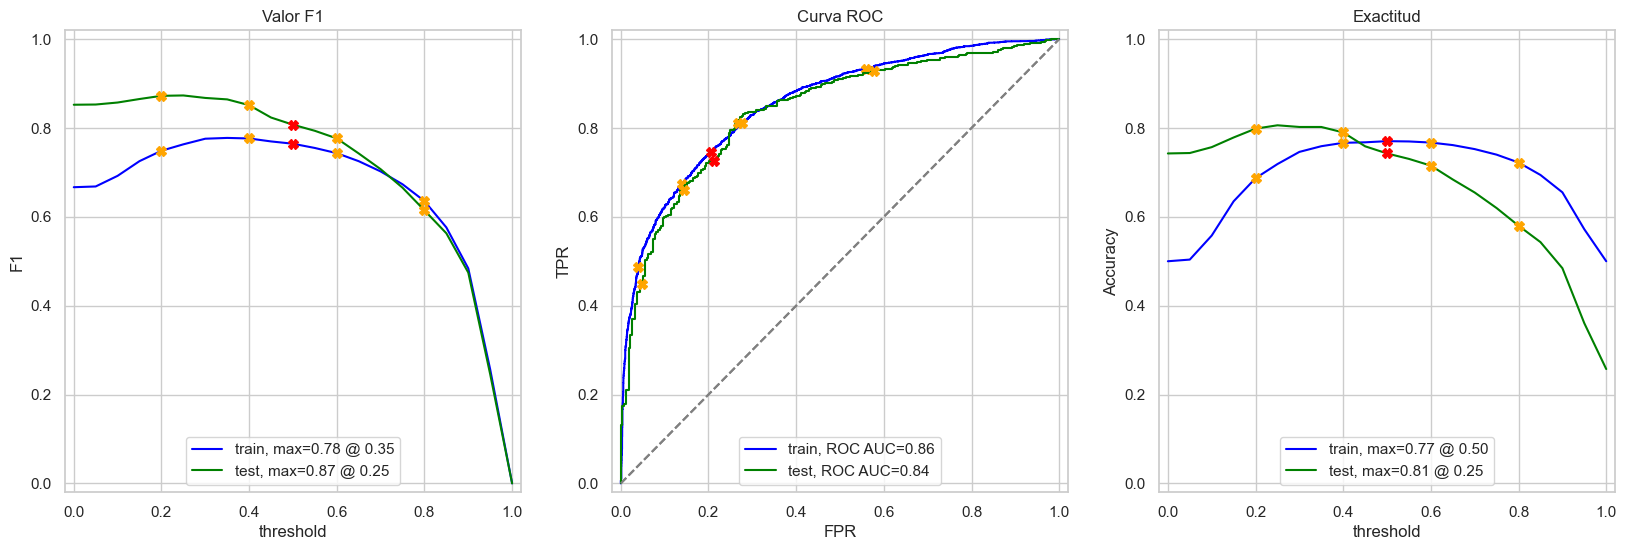

In [48]:
evaluate_model(linear_model, X_train_resampled, y_train_resampled, X_test, y_test, cv_enabled=True)

Observamos un buen desempeño del modelo lineal; la métrica ROC_AUC para el conjunto de entrenamiento y de prueba es muy cercana, lo que indica que el modelo es igualmente bueno identificando verdaderos positivos y negativos en ambos conjuntos. El umbral para la exactitud varía mucho entre los distintos grupos de datos, donde en las pruebas el umbral tuvo que reducirse para poder clasificar positivos.

Esto podría indicar sobreajuste. Para estar más seguros, corramos una prueba con los datos sin sobremuestreo utilizando el mismo modelo.

ROC AUC CV (mean): 0.85, (std): 0.02
          train  test
ROC AUC    0.86  0.84
Accuracy   0.73  0.80
F1         0.77  0.87


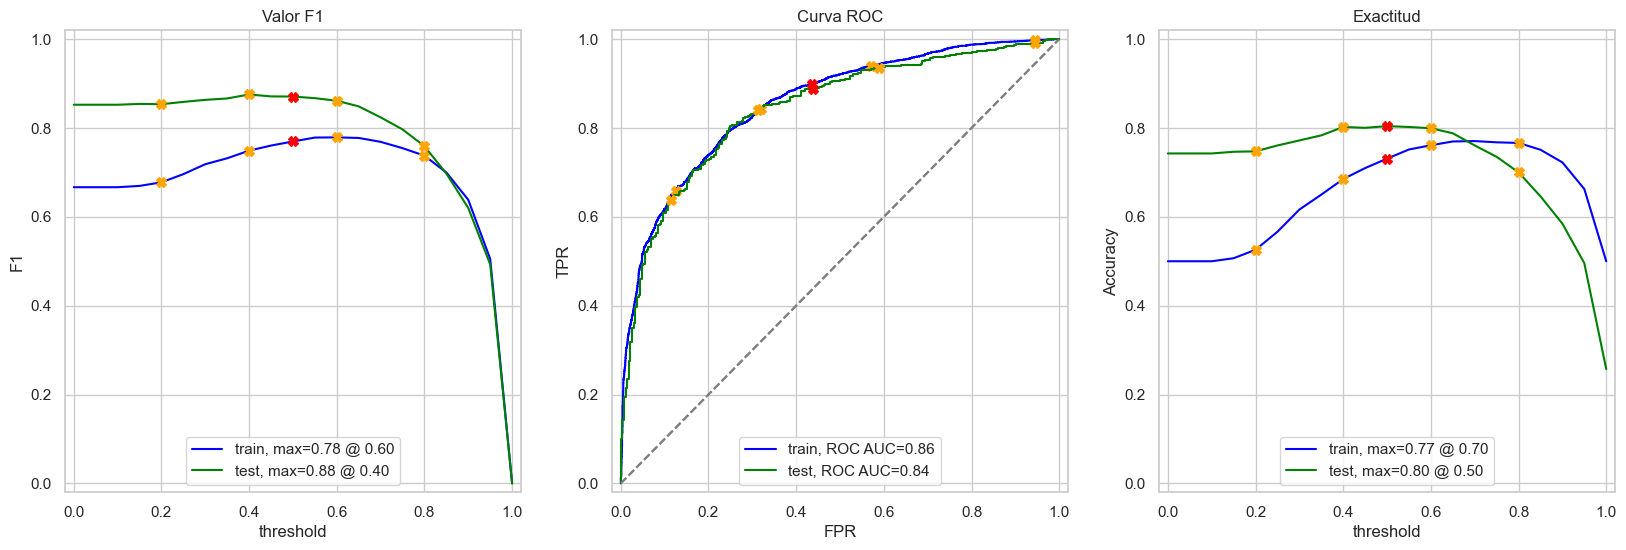

In [49]:
linear_model.fit(X_train, y_train)
evaluate_model(linear_model, X_train, y_train, X_test, y_test, cv_enabled=True)

Como vemos, la exactitud mejoró para un umbral más alto (cercano a 0.5, que sería el caso ideal para la clasificación binaria), lo cual nos arroja mejores resultados para el conjunto de prueba. Es posible que el conjunto de sobremuestreo esté generando un sobreajuste; lo comprobaremos con los otros modelos.

La métrica ROC-AUC mide la tasa entre VP y FP para cada punto (área bajo la curva), por lo que puede verse menos afectada por la distribución de clases.

### Modelo bosque aleatorio

Probaremos con ambos conjuntos de entrenamiento. Realizaremos una búsqueda de hiperparámetros para encontrar el mejor modelo.

In [55]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

forest_model_balanced = RandomForestClassifier(random_state=random_state, class_weight='balanced',)
forest_model_balanced = grid_search(forest_model_balanced, param_grid_rf, 5, X_train, y_train, n_jobs=-1)

ROC AUC CV (mean): 0.95, (std): 0.00
          train  test
ROC AUC    0.98  0.88
Accuracy   0.91  0.82
F1         0.92  0.87


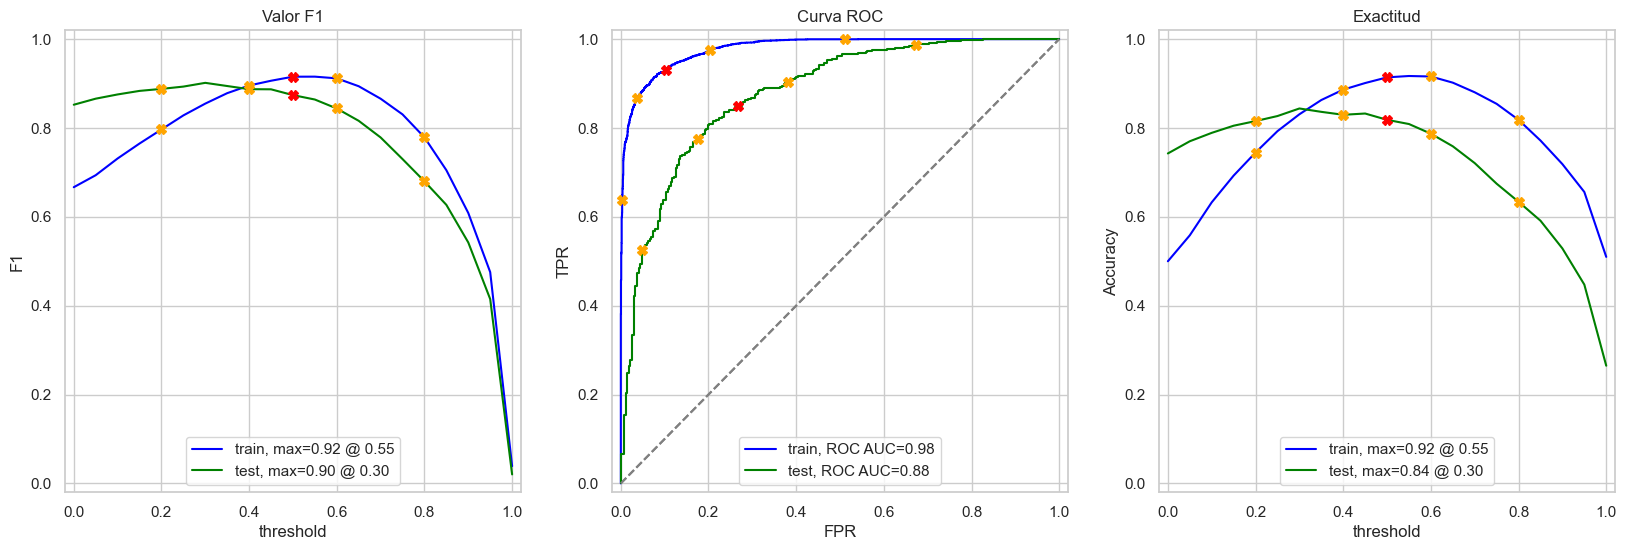

In [56]:
evaluate_model(forest_model_balanced, X_train, y_train, X_test, y_test, cv_enabled=True)

ROC AUC CV (mean): 0.96, (std): 0.00
          train  test
ROC AUC     1.0  0.89
Accuracy    1.0  0.83
F1          1.0  0.88


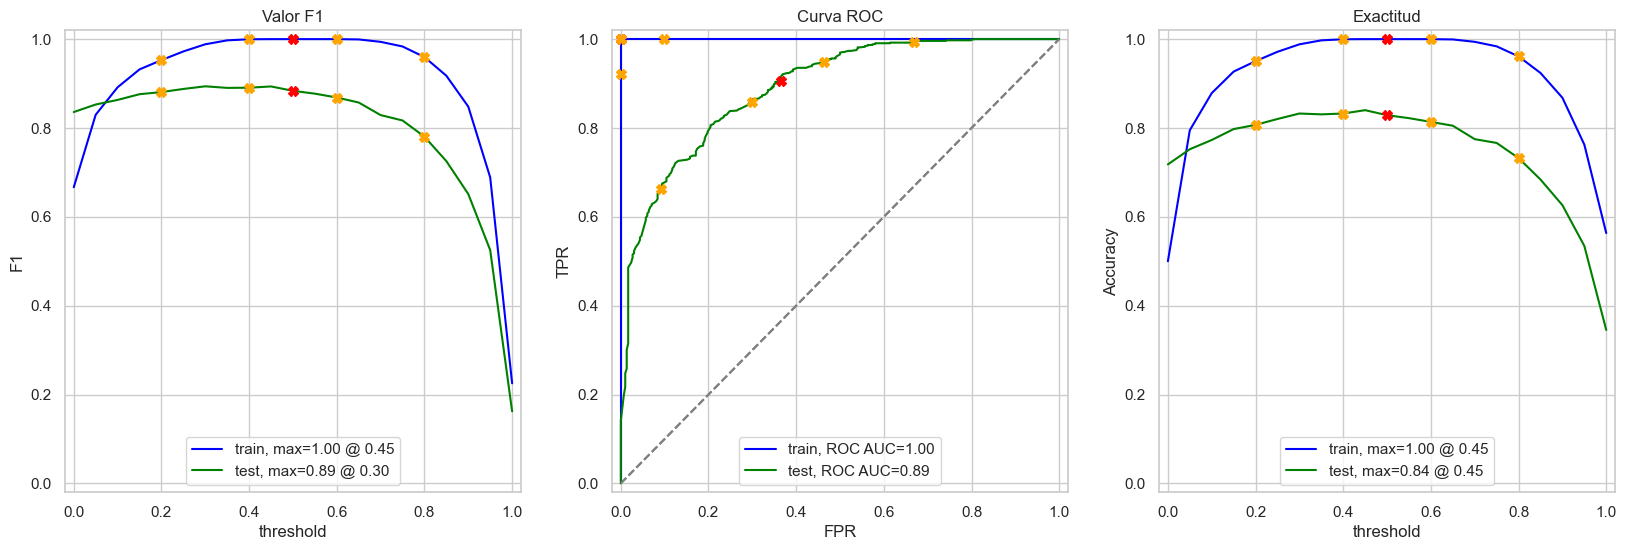

In [58]:
fores_model = RandomForestClassifier(random_state=random_state)
fores_model = grid_search(fores_model, param_grid_rf, 5, X_train_resampled, y_train_resampled, n_jobs=-1)

evaluate_model(fores_model, X_train_resampled, y_train_resampled, X_test, y_test, cv_enabled=True)

De nuevo, observamos una diferencia entre los resultados de los distintos conjuntos (con y sin sobremuestreo), principalmente en las métricas del conjunto de entrenamiento, donde todas son 1, lo que indica claramente un sobreajuste en los datos con sobremuestreo.

Claramente, el modelo tiene un mejor rendimiento con los datos originales y sin presentar un sobreajuste notable.

### Modelo XGBoost

ROC AUC CV (mean): 0.97, (std): 0.01
          train  test
ROC AUC     1.0  0.92
Accuracy    1.0  0.89
F1          1.0  0.93


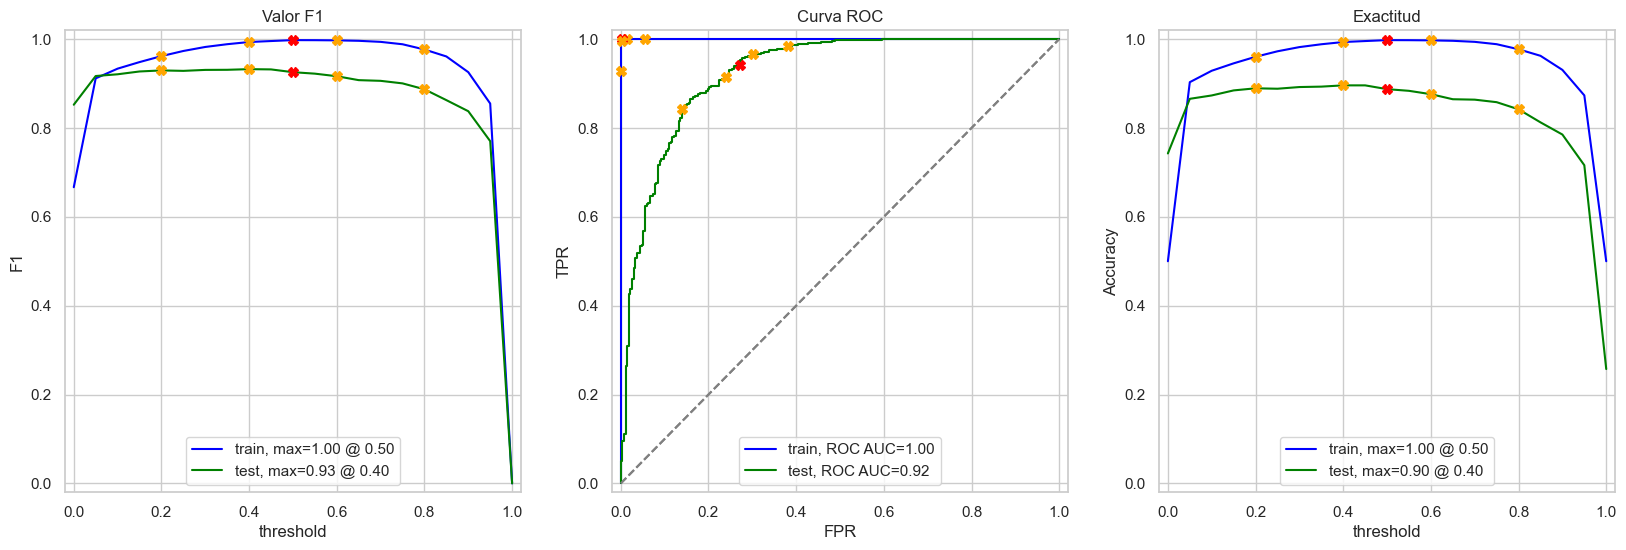

In [60]:
param_grid_xgboost = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

xbg_model = XGBClassifier(random_state=random_state)
xbg_model = grid_search(xbg_model, param_grid_xgboost, 5, X_train_resampled, y_train_resampled, n_jobs=1)

evaluate_model(xbg_model, X_train_resampled, y_train_resampled, X_test, y_test, cv_enabled=True)

ROC AUC CV (mean): 0.97, (std): 0.00
          train  test
ROC AUC    0.98  0.92
Accuracy   0.83  0.88
F1         0.85  0.92


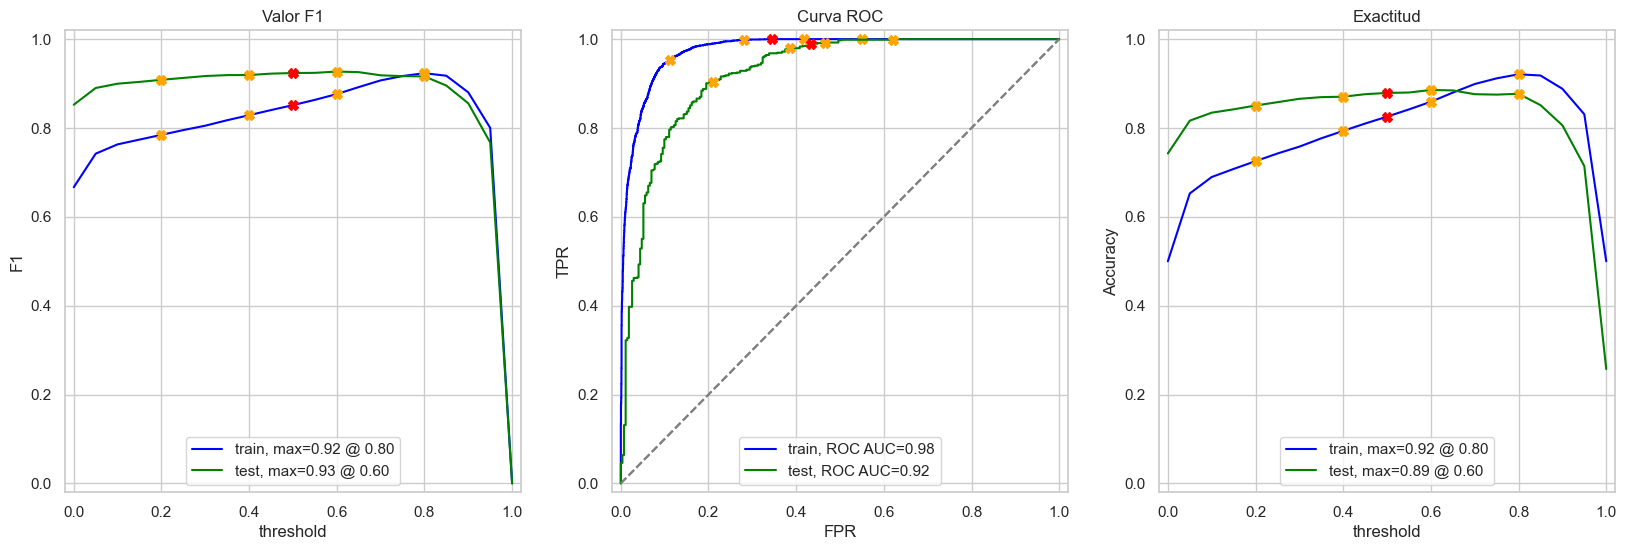

In [61]:
xbg_model = XGBClassifier(random_state=random_state, scale_pos_weight=2.7)
xbg_model = grid_search(xbg_model, param_grid_xgboost, 5, X_train, y_train, n_jobs=2)
evaluate_model(xbg_model, X_train, y_train, X_test, y_test, cv_enabled=True)

Observamos los mismos resultados que en el modelo anterior, pero esta vez el umbral de exactitud en el conjunto de prueba es casi perfecto, lo que nos indica que el modelo logra identificar correctamente las clases, además de obtener una excelente puntuación en ROC-AUC. En general, este es el mejor rendimiento hasta el momento.

### Modelo de red neuronal

Utilizaremos capas completamente conectadas en las que reduciremos logarítmicamente el número de unidades por capa. Realizaremos una búsqueda de hiperparámetros con la red y utilizaremos la precisión para medir el rendimiento del mejor modelo. Emplearemos el ROC_AUC para determinar el mejor candidato y también mostraremos la precisión.

In [50]:
param_grid_mlp = {
    'units': [32, 64],
    'epochs': [50, 75, 100],
    'batch_size': [32, 64]
}

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

# ignorar advertencias de deprecacion
warnings.filterwarnings('ignore', category=DeprecationWarning)

# convertimos los datos a arreglos de numpy para poder usarlos en keras
X_train_resampled_mlp = X_train_resampled.values
X_test_mlp = X_test.values

def create_mlp_model(units):
    model = Sequential()
    model.add(Dense(units, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dense(units // 4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # para clasificacion binaria
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# envoltorio para scikitlearn
wrapper = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_mlp_model, verbose=0)

In [ ]:
grid_search_mlp = GridSearchCV(estimator=wrapper, param_grid=param_grid_mlp, cv=3, scoring=scoring, refit='roc_auc', verbose=0)
grid_search_mlp_result = grid_search_mlp.fit(X_train_resampled_mlp, y_train_resampled)

34/34 [==============================] - 0s 483us/step
          train  test
ROC AUC    0.85  0.87
Accuracy   0.77  0.77
F1         0.77  0.82


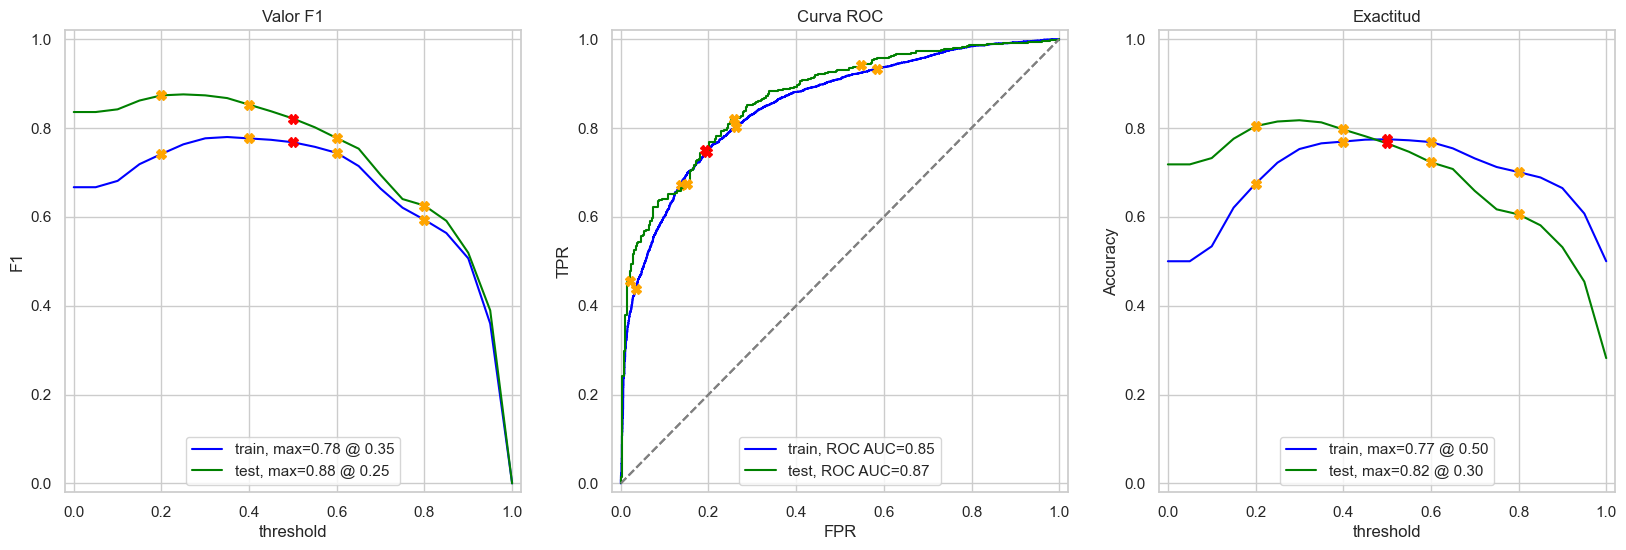

In [92]:
best_mlp_model = grid_search_mlp_result.best_estimator_
evaluate_model(best_mlp_model, X_train_resampled_mlp, y_train_resampled, X_test_mlp, y_test)

45/45 [==============================] - 0s 544us/step
ROC AUC CV (mean): 0.85, (std): 0.01
          train  test
ROC AUC    0.85  0.84
Accuracy   0.76  0.80
F1         0.78  0.86


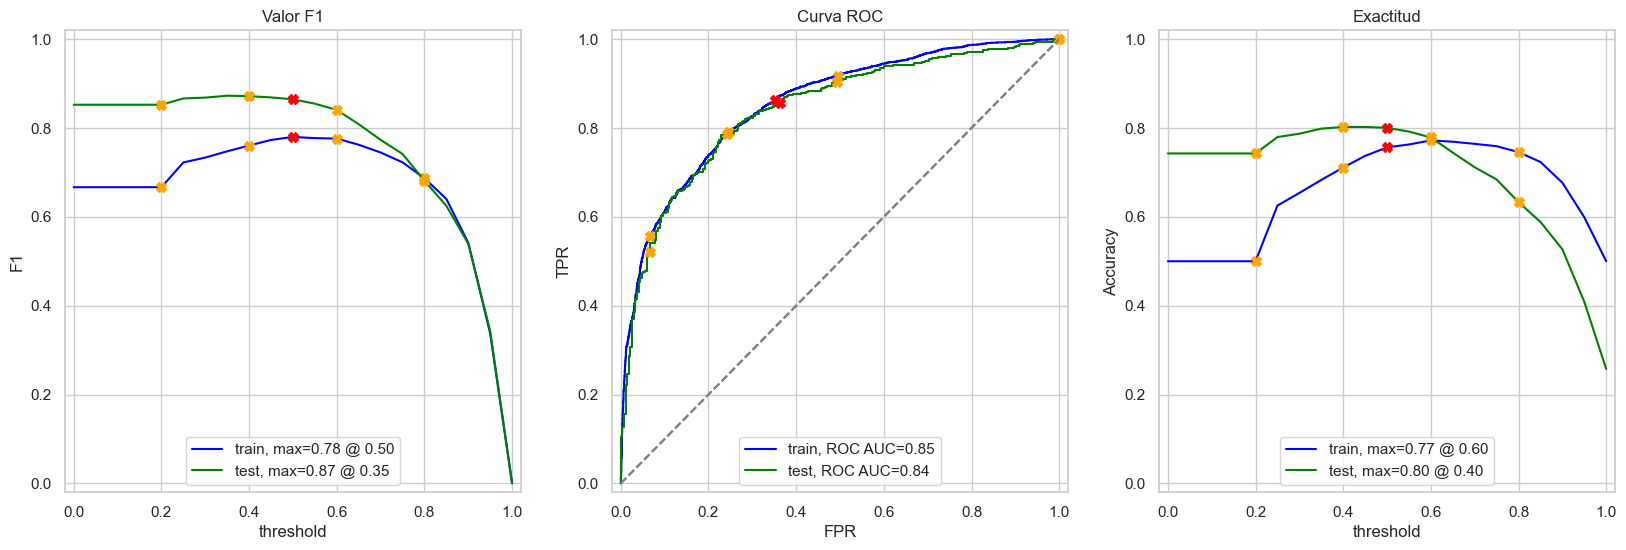

In [58]:
mlp = grid_search(wrapper, param_grid_mlp, 3, X_train, y_train, scoring=scoring, refit='roc_auc')
evaluate_model(mlp, X_train, y_train, X_test, y_test, cv_enabled=True)

## Resultados

| **Modelo**                   | **Conjunto**          | **ROC AUC** | **Accuracy** | **F1 Score** |
|------------------------------|-----------------------|-------------|--------------|--------------|
| **Regresión Logística**       | Entrenamiento         | 0.86        | 0.77         | 0.76         |
|                              | Prueba                | 0.84        | 0.74         | 0.81         |
| **Regresión Logística**       | Entrenamiento         | 0.86        | 0.73         | 0.77         |
| *(sin sobremuestreo)*         | Prueba                | 0.84        | 0.80         | 0.87         |
| **Random Forest**             | Entrenamiento         | 0.98        | 0.91         | 0.92         |
|                              | Prueba                | 0.88        | 0.82         | 0.87         |
| **Random Forest**             | Entrenamiento         | 1.00        | 1.00         | 1.00         |
| *(sin sobremuestreo)*         | Prueba                | 0.89        | 0.83         | 0.88         |
| **XGBoost**                   | Entrenamiento         | 1.00        | 0.99         | 0.99         |
|                              | Prueba                | 0.93        | 0.88         | 0.92         |
| **XGBoost**                   | Entrenamiento         | 0.97        | 0.88         | 0.89         |
| *(sin sobremuestreo)*         | Prueba                | 0.92        | 0.88         | 0.92         |
| **MLP**                       | Entrenamiento         | 0.85        | 0.77         | 0.77         |
|                               | Prueba                | 0.87        | 0.77         | 0.82         |
| **MLP**                       | Entrenamiento         | 0.50        | 0.50         | 0.67         |
| *(sin sobremuestreo)*         | Prueba                | 0.50        | 0.74         | 0.85         |


Observamos el desempeño de los modelos en ambos conjuntos: con sobremuestreo y sin él. Obtuvimos sobreajuste en los datos SMOTE, probablemente debido a la cantidad total de datos y al hecho de que el sobremuestreo representaba casi el triple en la sintetización de los datos. Con un conjunto de datos más grande y una proporción de train/test diferente, podríamos obtener mejores resultados con la técnica de sobremuestreo.

### Validación

Pasaremos a probar los datos de validacion en el mejor modelo.

ROC AUC CV (mean): 0.97, (std): 0.00
          train  test
ROC AUC    0.98  0.92
Accuracy   0.83  0.88
F1         0.85  0.93


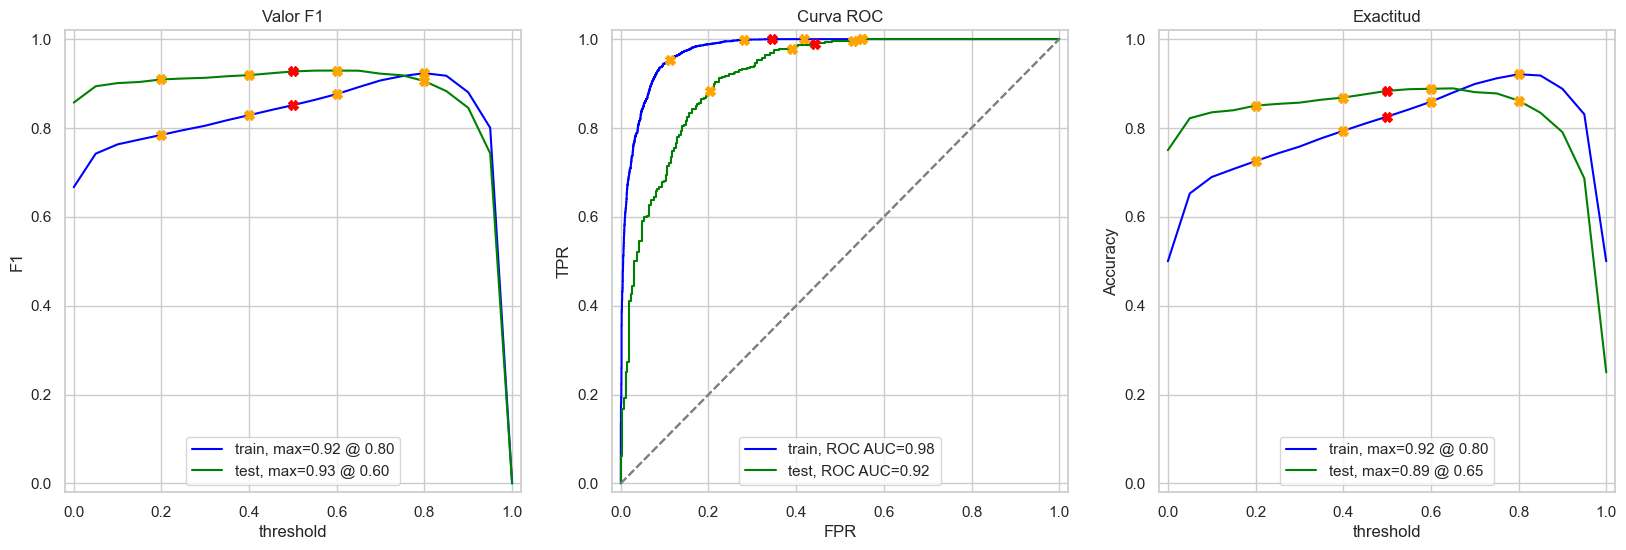

In [62]:
#xbg_model = grid_search(xbg_model, param_grid_xgboost, 5, X_valid, y_valid, n_jobs=2)
evaluate_model(xbg_model, X_train, y_train, X_valid, y_valid, cv_enabled=True)

## Conclusiones

El análisis realizado nos permitió identificar el mejor modelo para predecir la tasa de cancelación de clientes en la empresa Interconnect. Tras evaluar varios modelos, incluyendo Regresión Logística, Random Forest, XGBoost y una Red Neuronal, determinamos que el modelo de XGBoost proporciona el mejor rendimiento con un ROC AUC de 0.92 en el conjunto de prueba.

El uso de sobremuestreo para balancear las clases resultó en un sobreajuste en algunos modelos, particularmente en Random Forest. Sin embargo, la Red Neuronal y XGBoost mostraron ser más robustos frente a este problema.

Finalmente, recomendamos la implementación del modelo XGBoost para la predicción de cancelaciones, debido a su equilibrio entre precisión y capacidad de generalización. Como siguiente paso, se podría explorar una mayor optimización de hiperparámetros y la combinación de diferentes modelos para mejorar aún más la precisión de las predicciones.